# [Nanoparticle number concentration measurements by multi-angle dynamic light scattering](https://doi.org/10.1007/s11051-020-04840-8)

This python implementation is based on:

    Austin, J., Minelli, C., Hamilton, D. et al. Nanoparticle number concentration measurements by multi-angle dynamic light scattering. J Nanopart Res 22, 108 (2020).
    https://doi.org/10.1007/s11051-020-04840-8

## Parameters

In [1]:
basePath = r"analyse_dls_with_contin/testdata"
pathToluene = basePath+"/toluene"
pathBuffer = basePath+"/water"
pathSample = basePath+"/mw002-03"

### Refractive Index and density of particles
- **Polypropylene (PP)**: 1.492 and 0.91 g/mL  
  ( https://www.osapublishing.org/ao/abstract.cfm?uri=ao-42-3-592 )
- **Polystyrene (PS)**: 1.593 and 1.05 g/mL
- **Polyethylene (PE)**: 1.51 and 0.92 g/mL

In [2]:
# for Polypropylene, PP
refracParticle = 1.492
densityParticle = 0.91*1e6 # g/m^3

### CONTIN parameters to adjust

In [3]:
sizeRangeM = (1e-9, 300e-9)
fitRangeCrop = 20 # percentage of fit range width to ignore boundary peaks/artefacts in CONTIN results
                  # size range is extended by this amount
continConfig = dict(recalc=True,
    ptRangeSec=(3e-7, 1e0), fitRangeM=sizeRangeM, gridpts=200,
    transformData=True, baselineCoeffs=0, # N_L
    # weighs noise level of data points accordinly for photon correlation spectroscopy
    # where the variance of Y is proportional to (Y**2+1)/(4*Y**2)
    # (from contin.for, line 1430)
    weighResiduals=True,
)
if fitRangeCrop > 0 and fitRangeCrop < 100:
    continConfig['fitRangeM'] = (continConfig['fitRangeM'][0]*(1-fitRangeCrop/100),
                                 continConfig['fitRangeM'][1]*(1+fitRangeCrop/100))
continConfig

{'recalc': True,
 'ptRangeSec': (3e-07, 1.0),
 'fitRangeM': (8.000000000000001e-10, 3.6e-07),
 'gridpts': 200,
 'transformData': True,
 'baselineCoeffs': 0,
 'weighResiduals': True}

### More parameters to adjust

In [4]:
# Threshold for data to be included. Calculated by modified z-score based on median absolute deviation (MAD)
# of the measured count rate in https://github.com/BAMresearch/jupyter_analysis_tools/blob/main/analysis.py
countRateScoreMax = 1
# Threshold for a distribution to be included. Calculated by the median ratio of distribution value against
# its uncertainty which are determined by CONTIN. Kind of quality indicator for the solution found.
uncertRatioMax = 1

### Select measurement files for Toluene, Buffer and Sample

In [5]:
import numpy as np
from analyse_dls_with_contin.jupyter_analysis_tools.datalocations import getDataDirs, getDataFiles, printFileList

In [6]:
tolueneFiles = getDataFiles(pathToluene, include="*.ASC", exclude="_average")
assert len(tolueneFiles), "No files for Toluene selected!"
printFileList(tolueneFiles, numParts=10)

6 files to be analyzed in subdirectories.
     analyse_dls_with_contin/testdata/toluene/092 2021 Toluol0000_0001.ASC
     analyse_dls_with_contin/testdata/toluene/092 2021 Toluol0000_0002.ASC
     analyse_dls_with_contin/testdata/toluene/092 2021 Toluol0000_0003.ASC
     analyse_dls_with_contin/testdata/toluene/092 2021 Toluol0001_0001.ASC
     analyse_dls_with_contin/testdata/toluene/092 2021 Toluol0001_0002.ASC
     analyse_dls_with_contin/testdata/toluene/092 2021 Toluol0001_0003.ASC


In [7]:
bufferFiles = getDataFiles(pathBuffer, include="*.ASC", exclude="_average")
assert len(bufferFiles), "No files for the buffer selected!"
printFileList(bufferFiles, numParts=10)

6 files to be analyzed in subdirectories.
     analyse_dls_with_contin/testdata/water/093 2021 Wasser0000_0001.ASC
     analyse_dls_with_contin/testdata/water/093 2021 Wasser0000_0002.ASC
     analyse_dls_with_contin/testdata/water/093 2021 Wasser0000_0003.ASC
     analyse_dls_with_contin/testdata/water/093 2021 Wasser0001_0001.ASC
     analyse_dls_with_contin/testdata/water/093 2021 Wasser0001_0002.ASC
     analyse_dls_with_contin/testdata/water/093 2021 Wasser0001_0003.ASC


In [8]:
#particleFiles = getDataFiles(pathSample, include="*averaged.ASC")
particleFiles = getDataFiles(pathSample, include="*.ASC", exclude="_average")
assert len(particleFiles), "No files for the particles selected!"
printFileList(particleFiles, numParts=10)

6 files to be analyzed in subdirectories.
     analyse_dls_with_contin/testdata/mw002-03/7 2021 MW002-030000_0001.ASC
     analyse_dls_with_contin/testdata/mw002-03/7 2021 MW002-030000_0002.ASC
     analyse_dls_with_contin/testdata/mw002-03/7 2021 MW002-030000_0003.ASC
     analyse_dls_with_contin/testdata/mw002-03/7 2021 MW002-030001_0001.ASC
     analyse_dls_with_contin/testdata/mw002-03/7 2021 MW002-030001_0002.ASC
     analyse_dls_with_contin/testdata/mw002-03/7 2021 MW002-030001_0003.ASC


## No further parameters to adjust beyond this line
---

## Read DLS intensity (count rate) and normalize its scaling across measurements

In [9]:
# derived from '2020-07-31 DLS concentration vs. count rate'
import os
from pathlib import Path
import pandas as pd
from analyse_dls_with_contin.dlshelpers import getDLSFileData
    
def processDLSMeasurements(files, monitorDiodeRef=0, monitorDiodeScale=1):
    """Treat a set of files as measurement of the same sample,
       at different scattering angles and with repetitions, possibly.
       Returns count rate averages and std. deviations for each angle."""
    if isinstance(files, str):
        files = (files,)
    # gather all relevant data from files in a directory
    dirData = [getDLSFileData(fn) for fn in files]
    if not len(dirData):
        return {}
    #print(dirData)
    # create a DataFrame from that
    columns = set([key for fileData in dirData for key in fileData.keys()
                   if key not in ("correlation", "countrate", "angles", "meancr", "sampleName", "filename")])
    df = pd.DataFrame({key: [fileData.get(key, None) for fileData in dirData]
                       for key in columns})
    name = '+'.join(list(set([Path(fn).parent.name for fn in files])))
    summary = dict(name=name, timestamp=df.timestamp[0],
                   concentration=df.concentration[0])
    if "monitorDiode" in df.columns:
        if monitorDiodeRef != 0:
            monitorDiodeScale = monitorDiodeRef / df.monitorDiode.mean()
        summary.update(dict(monitorDiode=df.monitorDiode.mean()))
        print("Monitor diode reference: {:.0f}, this mon. diode: {:7.0f}, scale: {:.6f} ({})"
              .format(monitorDiodeRef, summary['monitorDiode'], monitorDiodeScale, summary['name']))
    summary.update(dict(monitorDiodeScale=monitorDiodeScale))
    for name in ("Temperature", "Viscosity", "Refractive Index", "Wavelength"):
        for colname in df.columns:
           if colname.startswith(name):
               summary[colname] = df[colname].mean()
    # all sets of angles found in files in this directory, a set can have unique entries only
    dirAngles = set([tuple(fileData['angles']) for fileData in dirData])
    countRates, countRateMeans, attenuation = [], [], []
    for angles in dirAngles:
        # concatenate countrates (time series) of the same set of angles only
        # averaging count rates over time later
        countRates.append(pd.concat([fileData.get('countrate', pd.DataFrame())
                                     for fileData in dirData
                                     if tuple(fileData['angles']) == angles]))
        countRateMeans.append(pd.concat([fileData.get('meancr', pd.DataFrame())
                                     for fileData in dirData
                                     if tuple(fileData['angles']) == angles]))
        attenuation.append(pd.concat([fileData.get('attenuation', pd.DataFrame())
                                     for fileData in dirData
                                     if tuple(fileData['angles']) == angles]))
    # count rate mean over all measurements (must be at same angles!)
    countRates = pd.concat(countRates, axis=1)*monitorDiodeScale
    countRateMeans = pd.concat(countRateMeans, axis=1)*monitorDiodeScale
    countRates.sort_index(axis=1, inplace=True)
    countRateMeans.sort_index(axis=1, inplace=True)
    # compensating for attenuation, expected to be identical across all measurements
    attenuationInv = 1/pd.concat(attenuation, axis=1).mean()
    countRates *= attenuationInv
    countRateMeans *= attenuationInv
    def seriesToDict(series, lbl):
        return {"{}{:.0f}".format(lbl, key): value for key, value in zip(series.index, series.values)}
    if not countRates.empty:
        summary.update(seriesToDict(countRates.mean(), 'crmean'))
        summary.update(seriesToDict(countRates.std(), 'crstd'))
    else:
        summary.update(seriesToDict(countRateMeans.mean(), 'crmean'))
        summary.update(seriesToDict(countRateMeans.std(), 'crstd'))
    summary.update(angles=countRateMeans.columns.astype(int).tolist())
    print("Measurement angles:", summary['angles'])
    return summary

def crAtAngle(summaryDict, degrees):
    return (summaryDict.get(f'crmean{degrees:.0f}', -1.),
            summaryDict.get(f'crstd{degrees:.0f}', -1.))

def crMean(summaryDict):
     return np.array([crAtAngle(summaryDict, theta)[0] for theta in getAngles(summaryDict)])

def getAngles(summaryDict):
    return summaryDict.get('angles', []) if summaryDict else []

In [10]:
tolueneData = processDLSMeasurements(tolueneFiles)
crTol_mean = crMean(tolueneData)
#tolueneData, crTol_mean

Monitor diode reference: 0, this mon. diode: 1567735, scale: 1.000000 (toluene)
Measurement angles: [26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]


In [11]:
bufferData = processDLSMeasurements(bufferFiles, monitorDiodeRef=tolueneData['monitorDiode'])
crBuf_mean = crMean(bufferData)
#bufferData, crBuf_mean

Monitor diode reference: 1567735, this mon. diode: 1563499, scale: 1.002709 (water)
Measurement angles: [26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]


In [12]:
if all(("_averaged.ASC" in fn for fn in particleFiles)):
    # hotfix for averaged files, compare with non-avg files:
    # Monitor diode reference: 1567735, this mon. diode:   21146, scale: 74.138438 (094 2021 PS-Standard 1zu1000)
    particleData = processDLSMeasurements(particleFiles, monitorDiodeScale=74.138438)
else:
    particleData = processDLSMeasurements(particleFiles, monitorDiodeRef=tolueneData['monitorDiode'])
particleData['density'] = densityParticle
crTot_mean = crMean(particleData)
#particleData, crTot_mean

Monitor diode reference: 1567735, this mon. diode:   22993, scale: 68.184414 (mw002-03)
Measurement angles: [26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 130, 138, 146]


## Count Rate (scattering intensity) across all measured angles

Covering particle, Toluene and Buffer/Water measurements

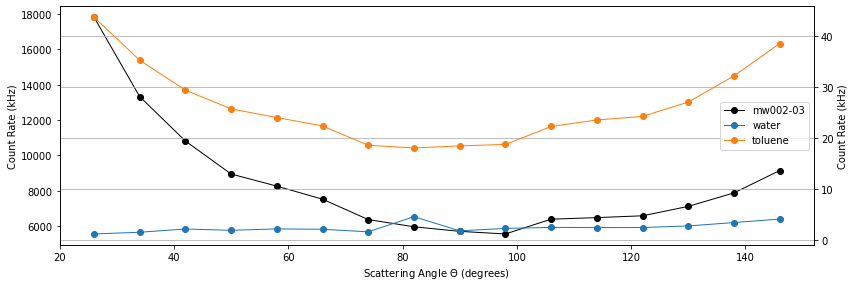

In [13]:
import matplotlib.pyplot as plt
from analyse_dls_with_contin.jupyter_analysis_tools.plotting import createFigure
def plotCountRateAllAngles(summaryData, newfig=False, **kwargs):
    if newfig:
        createFigure(300, 3, quiet=True, tight_layout = {'pad': 0.5});
    angles = getAngles(summaryData)
    crmean = crMean(summaryData)
    plt.plot(angles, crmean, marker='o', lw=1, label=summaryData['name'], **kwargs);
    plt.ylabel(r"Count Rate (kHz)")
    plt.xlabel(r"Scattering Angle $\Theta$ (degrees)");

plotCountRateAllAngles(particleData, newfig=True, color="black")
handles1, labels1 = plt.gca().get_legend_handles_labels()
ax2 = plt.gca().twinx()
plotCountRateAllAngles(bufferData)
plotCountRateAllAngles(tolueneData)
handles2, labels2 = plt.gca().get_legend_handles_labels()
# final plot config with combined legend
plt.legend(handles1+handles2, labels1+labels2)
plt.grid();

## Get the size distribution

**According to Malvern:**  
*"The first order result from a DLS experiment is an intensity distribution of particle sizes. The intensity distribution is naturally weighted according to the scattering intensity of each particle fraction or family. For biological materials or polymers the particle scattering intensity is proportional to the square of the molecular weight."*  
( https://www.chem.uci.edu/~dmitryf/manuals/Fundamentals/DLS%20terminology.pdf )

**Check:**  
[The CONTIN algorithm and its application to determine the size distribution of microgel suspensions ](https://doi.org/10.1063/1.4921686)

### Run CONTIN

In [14]:
from analyse_dls_with_contin.jupyter_analysis_tools.utils import updatedDict
continConfigs = [updatedDict(continConfig, 'angle', angle)
                 for angle in getAngles(particleData)]
#continConfigs

In [ ]:
from analyse_dls_with_contin.contin import runContinOverFiles
resultDirs = runContinOverFiles(particleFiles, continConfigs, nthreads=None)
#resultDirs

## The differential scattering cross section
Using [miepython](https://miepython.readthedocs.io/en/latest/index.html):

See also https://miepython.readthedocs.io/en/latest/03_angular_scattering.html#Differential-Scattering-Cross-Section  
cites [Wiscombe, W. J. (1979). Mie Scattering Calculations. doi:10.5065/D6ZP4414](https://opensky.ucar.edu/islandora/object/technotes:232)

In [ ]:
#!pip install miepython # install miepython module

In [ ]:
import miepython
from analyse_dls_with_contin.jupyter_analysis_tools.utils import isList
def diffScatteringCrossSection(radius, angles, wavelen, nMedium, verbose=False):
    geometric_cross_section = np.pi * radius**2 * 1e-14 # cm**2
    if not isList(angles):
        angles = np.array([angles])
    mu = np.cos(np.radians(angles))
    m = refracParticle/nMedium
    x = np.pi*2*radius/(wavelen/nMedium)
    if verbose:
        print(wavelen, 2*radius, nMedium, refracParticle/nMedium, x, geometric_cross_section)
    qext, qsca, qback, g = miepython.mie(m,x)
    return geometric_cross_section * qext * miepython.i_unpolarized(m,x,mu)

## Rayleigh ratio
*"The Rayleigh ratio of toluene is known from the literature and is equal to 1.35·10e−5·cm−1 at 632.8 nm and 25 °C (Brar and Verma 2011)"*

In [ ]:
rayleighRatioToluene = 1.35e-5*1e2 # in 1/m at wavelength of 632.8 nm and 25 °C

## Calculate and plot the concentration distributions

In [ ]:
import matplotlib.pyplot as plt
from analyse_dls_with_contin.jupyter_analysis_tools.plotting import createFigure
from analyse_dls_with_contin.jupyter_analysis_tools.distrib import (Distribution,
    integrate, normalizeDistrib, findPeakRanges, findLocalMinima)
from analyse_dls_with_contin.contin import getContinResults
import numpy as np

def getConcentration(continResultDir, particleData, bufferData, tolueneData,
                     countRateScoreMax=1., uncertRatioMax=1., plotRangeX=None, plot=False):
    """Implements [equation 8 in Austin 2020](https://link.springer.com/content/pdf/10.1007/s11051-020-04840-8.pdf)."""
    dfDistrib, dfFit, varmap = getContinResults(continResultDir)
    if fitRangeCrop > 0 and fitRangeCrop < 100:
        # cropping distribution result by *fitRangeCrop* CONTIN parameter above
        # percentage of fit range width to ignore boundary peaks/artefacts on
        rmin = dfDistrib.radius.min()/(1-fitRangeCrop/100)
        rmax = dfDistrib.radius.max()/(1+fitRangeCrop/100)
        #print(rmin, rmax)
        rmin = np.argwhere(dfDistrib.radius.values > rmin)[0][0]
        rmax = np.argwhere(dfDistrib.radius.values < rmax)[-1][0]
        #print(rmin, rmax)
        dfDistrib = dfDistrib[rmin:rmax+1]
    if all(dfDistrib.distrib == 0.):
        return {} # skip this one, no distribution found
    distrib = Distribution(dfDistrib.radius, dfDistrib.distrib, dfDistrib.err, maxPeakCount=1)
    if varmap.get('score', 1.0) > countRateScoreMax:
        return {} # skip this one, data score too bad
    if not len(distrib.peaks) or distrib.uncertRatioMedian(distrib.peaks[0]) > uncertRatioMax:
        return {} # skip this one, distribution peak uncertainty to large
    x, y, u = distrib.peakData(distrib.peaks[0])
    theta = varmap['angle']
    I_tot, _ = crAtAngle(particleData, theta)
    I_dis, _ = crAtAngle(bufferData, theta)
    I_tol, _ = crAtAngle(tolueneData, theta)
    intensity = (I_tot - I_dis) * rayleighRatioToluene / (I_tol)
    wavelen = bufferData["Wavelength [nm]"]
    nMedium = bufferData["Refractive Index"]
    sigma_sca = np.array([diffScatteringCrossSection(radius, theta, wavelen, nMedium)
                          for radius in x*1e9]).flatten()*1e-4 # in m^-2
    concentrationNumbers = y * intensity / sigma_sca # in m^-3
    concentrationNumbers *= 1e-6 # convert to 1/mL
    concentrationNumbersSum = integrate(x, concentrationNumbers)
    volumes = np.pi * x**3 * 4/3 # in m^3
    concentrationMass = particleData['density'] * volumes * concentrationNumbers
    concentrationMassSum = integrate(x, concentrationMass)
    if plot:
        createFigure(300, 2, quiet=True, tight_layout = {'pad': 0.05});
        plt.subplot(3,2,1); plt.grid()
        distPar, moments = distrib.peakDistrPar(plotAxes=[plt.gca()], showFullRange=True)
        plt.title(continResultDir.name+"\n("+(f"score: {varmap['score']}, " if 'score' in varmap else "")
                  +"$U_{ratio}$: "+f"{distrib.uncertRatioMedian(distrib.peaks[0]):.3f})")
        plt.subplot(3,2,2); plt.grid()
        plt.semilogy(x, sigma_sca)
        plt.title("Diff. scattering cross section (m$^2$/sr)")
        plt.xlim(plotRangeX);
        
        plt.subplot(3,1,2); plt.grid()
        plt.plot(x, concentrationNumbers,
                 label=r"1/mL=$\int$"+"{:.3g}".format(concentrationNumbersSum));
        plt.ylabel("Numbers / mL")
        handles1, labels1 = plt.gca().get_legend_handles_labels()
        ax2 = plt.gca().twinx()
        ax2.plot(x, concentrationMass, color="green",
                 label=r"g/mL=$\int$"+"{:.3g}".format(concentrationMassSum));
        ax2.set_ylabel("g / mL")
        handles2, labels2 = plt.gca().get_legend_handles_labels()
        plt.xlim(plotRangeX);
        plt.legend(handles1+handles2, labels1+labels2)
    # Return concentration values determined along with Moments and LogNorm params for the first peak
    return ({"angle": theta, "cNumbers": concentrationNumbersSum, "cMass": concentrationMassSum}
            | moments[0] | distPar[0])

concentrations = [getConcentration(dn, particleData, bufferData, tolueneData,
                                   countRateScoreMax=countRateScoreMax, uncertRatioMax=uncertRatioMax,
                                   plotRangeX=sizeRangeM, plot=True)
                  for dn in sorted(resultDirs)]
#concentrations

In [ ]:
concentrations = pd.DataFrame(concentrations).dropna()
concentrations

## Median concentration across all measured angles

In [ ]:
from analyse_dls_with_contin.jupyter_analysis_tools.utils import fmtErr
if not len(concentrations):
    print("No concentrations found!")
else:
    createFigure(300, 1, quiet=True, tight_layout = {'w_pad': 2});
    ax = plt.subplot(3,1,1)
    cNumberMed = np.median(concentrations.cNumbers)
    concentrations.plot('angle', 'cNumbers', marker='.', ax=ax, lw=0, grid=True,
        label=f"Number concentration, median: {cNumberMed:.3g}"+" $mL^{-1}$");
    ax.hlines(cNumberMed, concentrations.angle.min(), concentrations.angle.max(), linestyles="dashed")
    ax.set_ylabel(r"Concentration in 1 / mL")
    ax.set_xlabel(r"Scattering Angle $\Theta$ (degrees)");
    #plt.ylim(0,np.median(concentrations.cNumbers)*3);
    ax = plt.subplot(3,1,2)
    cMassMed = np.median(concentrations.cMass)
    concentrations.plot('angle', 'cMass', marker='.', ax=ax, lw=0, grid=True, color='green',
        label=f"Mass concentration, median: {cMassMed:.3g}"+" $g\,/\,mL$");
    ax.hlines(cMassMed, concentrations.angle.min(), concentrations.angle.max(), linestyles="dashed", color='green')
    ax.set_ylabel(r"Concentration in g / mL")
    ax.set_xlabel(r"Scattering Angle $\Theta$ (degrees)");
    #plt.ylim(0,np.median(concentrations.cMass)*2);
    ax = plt.subplot(3,1,3)
    mean = np.array((concentrations['mean'].mean(), concentrations['mean'].std()))
    concentrations.plot('angle', 'mean', marker='.', ax=ax, lw=0, grid=True, color='red',
        label=f"Radius mean of means: {fmtErr(*mean*1e9)} nm");
    ax.hlines(mean[0], concentrations.angle.min(), concentrations.angle.max(), linestyles="dashed", color='red')
    ax.set_ylabel(r"Radius mean in nm")
    ax.set_xlabel(r"Scattering Angle $\Theta$ (degrees)");